# Variational AutoEncoder (VAE) Steps for Image Compression

1. **Imports** – Import TensorFlow, Keras layers, OpenCV, NumPy, Matplotlib, etc.

2. **Load Dataset** – Load images from disk (optionally limit number for testing).

3. **Prepare Data** – Normalize pixel values, add channel dimension, split into train/test sets.

4. **User Input / Compression Control** – Optionally, let user specify desired compression ratio or latent space size.

5. **Build VAE Model**  
   - **Encoder:** Convolutional layers to produce `z_mean` and `z_log_var`  
   - **Sampling layer:** Reparameterization trick to generate latent `z`  
   - **Decoder:** Transposed convolution layers to reconstruct the image

6. **Compile VAE** – Choose optimizer and loss function (e.g., `MeanSquaredError`).

7. **Train VAE** – Fit the model on training data with validation on test data.

8. **Save VAE Weights/Model** – Save trained model weights or full model.

9. **Load VAE Model** – Load saved weights or model for inference.

10. **Encode & Decode Images** – Use encoder to get latent representation and decoder to reconstruct.

11. **Visualize Results** – Compare original vs reconstructed images using plots.

12. **Compute Compression Ratio** – Compare original image bytes vs latent bytes.


In [112]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, losses
import matplotlib.pyplot as plt


In [113]:
import os
import numpy as np
import cv2

In [114]:
def load_data(img_dir, limit=200):
    x_train = []
    image_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".png")][:limit]
    for image_path in image_paths:
        img = cv2.imread(image_path, 0)  # grayscale
        if img is not None:
            x_train.append(img)
    return np.array(x_train)

data = load_data("/content/data/ffhq/Images/ffhq256", limit=200)



In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("denislukovnikov/ffhq256-images-only")

print("Path to dataset files:", path)

100%|██████████| 6.91G/6.91G [03:06<00:00, 39.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/denislukovnikov/ffhq256-images-only/versions/1


In [115]:

data = data.astype('float32') / 255.
split = int(0.8 * len(data))
x_train = data[:split][..., np.newaxis]
x_test  = data[split:][..., np.newaxis]



## Sampling Layer in VAE

The latent vector is sampled as:

$$
z = z_{\text{mean}} + \epsilon \cdot \sigma, \quad
\epsilon \sim \mathcal{N}(0,1), \quad
\sigma = e^{0.5 \, z_{\text{log\_var}}}
$$

**Explanation:**

1. This uses a probabilistic latent space instead of a fixed deterministic vector.  
2. `z_mean` and `z_log_var` are outputs of the encoder representing the parameters of a Gaussian distribution for each latent variable.  
3. We sample `z` from the Gaussian using the reparameterization trick, which allows gradients to backpropagate through stochastic sampling.  

**Difference from Standard AutoEncoders:**  

- Standard autoencoders directly output a fixed latent vector, whereas VAEs sample from a learned distribution, introducing randomness and regularization.


In [117]:



class Sampling(layers.Layer):
    def call(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, latent_channels):
        super(VAE, self).__init__()
        H, W = 256, 256
        h, w = H // 16, W // 16
        self.latent_channels = latent_channels

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(H,W,1)),
            layers.Conv2D(32,3,strides=2,padding='same',activation='relu'),
            layers.Conv2D(64,3,strides=2,padding='same',activation='relu'),
            layers.Conv2D(32,3,strides=2,padding='same',activation='relu'),
            layers.Conv2D(latent_channels,3,strides=2,padding='same',activation='relu')
        ])
        self.flatten = layers.Flatten()
        self.z_mean_layer = layers.Dense(latent_channels)
        self.z_log_var_layer = layers.Dense(latent_channels)
        self.sampling = Sampling()

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(latent_channels,)),
            layers.Dense(h*w*latent_channels, activation='relu'),
            layers.Reshape((h,w,latent_channels)),
            layers.Conv2DTranspose(32,3,strides=2,padding='same',activation='relu'),
            layers.Conv2DTranspose(64,3,strides=2,padding='same',activation='relu'),
            layers.Conv2DTranspose(32,3,strides=2,padding='same',activation='relu'),
            layers.Conv2DTranspose(1,3,strides=2,padding='same',activation='sigmoid')
        ])

    def encode(self, x):
        x_enc = self.encoder(x)
        x_flat = self.flatten(x_enc)
        z_mean = self.z_mean_layer(x_flat)
        z_log_var = self.z_log_var_layer(x_flat)
        z = self.sampling(z_mean, z_log_var)
        return z, z_mean, z_log_var

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        z, z_mean, z_log_var = self.encode(x)
        x_dec = self.decode(z)
        return x_dec



***Encoder*** `takes the input image and applies the multiple convolutional layers
`--->`Extracts the features.
Flatten converts final feature map to 1d vector.`

``z_mean_layer` and `z_log_var_layer` generate latent mean and log variance for each latent dimension.`

`These are used by the Sampling layer to produce the stochastic latent vector z.`

***Difference from AutoEncoder:***
`Standard AE: Encoder outputs single deterministic latent vector.`

`VAE: Encoder outputs parameters of a Gaussian distribution (`z_mean`, `z_log_var`) `→` introduces variability and probabilistic modeling.`

`The decoder reconstructs images from the latent vector z.`

`Dense layer expands the latent vector into a 3D feature map.`

`Conv2DTranspose layers upsample the feature maps back to the original image resolution.`

`Final sigmoid ensures output pixels are in `[0,1]`.`

***Difference from AutoEncoder:***

`Decoder is structurally similar to AE.
The main difference is it receives a stochastic latent vector sampled from a Gaussian distribution rather than a deterministic one.`

`Applies encoder → flatten → compute z_mean and z_log_var → sample z`.

Returns:

`z → latent vector for reconstruction`

`z_mean and z_log_var → used for computing KL divergence loss during training`

Difference from AutoEncoder:

AE just returns latent vector.

`VAE returns latent vector + distribution parameters → needed for regularization and compression ratio estimation.`

## KL Divergence Loss

The KL divergence loss in a VAE is:

$$
\text{KL} = -0.5 \sum \Big( 1 + z_{\text{log\_var}} - z_{\text{mean}}^2 - e^{\,z_{\text{log\_var}}} \Big)
$$

**Explanation / Difference from AutoEncoder:**

- **AutoEncoder (AE):** only minimizes reconstruction loss.  
- **Variational AutoEncoder (VAE):** minimizes **reconstruction + KL divergence**, forcing the latent space to approximate a **standard normal distribution**, resulting in better generative properties and a smoother latent space.


In [118]:
latent_channels = 16  # or calculate from user-defined compression ratio
vae = VAE(latent_channels)
vae.compile(optimizer='adam', loss=losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, validation_data=(x_test, x_test))


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 832ms/step - loss: 0.0638 - val_loss: 0.0625
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0654 - val_loss: 0.0622
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0658 - val_loss: 0.0616
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0649 - val_loss: 0.0608
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0656 - val_loss: 0.0598
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0641 - val_loss: 0.0589
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0625 - val_loss: 0.0585
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0629 - val_loss: 0.0580
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0623 - val_loss: 0.0576
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0614 - val_loss: 0.0539


In [122]:
vae.save_weights("vae_weights.weights.h5")


In [129]:
vae.load_weights("/content/data/ffhq/vae_weights.weights.h5")




In [130]:
z, _, _ = vae.encode(x_test)
decoded_imgs = vae.decode(z).numpy()


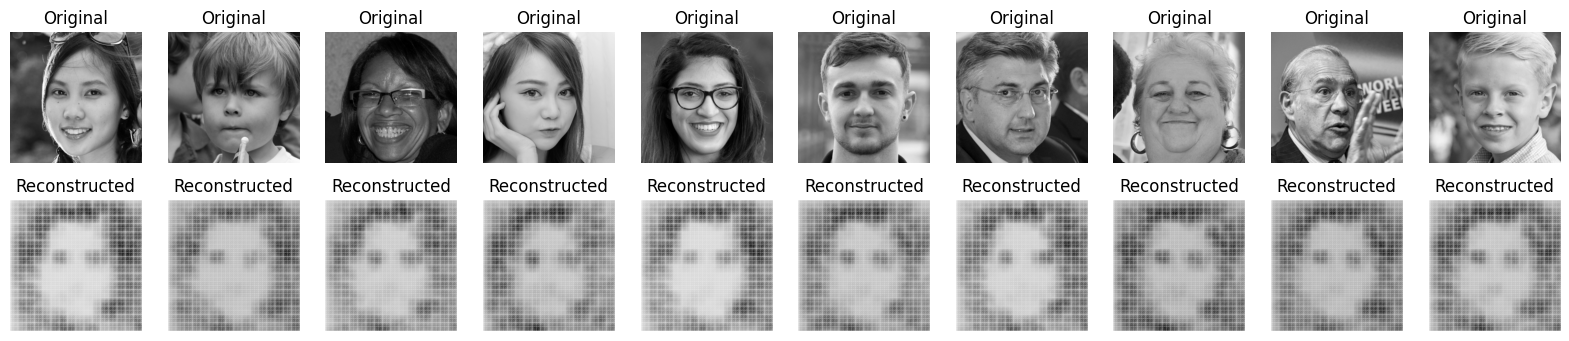

In [131]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(tf.squeeze(x_test[i])); plt.title("Original"); plt.gray(); ax.axis('off')
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(tf.squeeze(decoded_imgs[i])); plt.title("Reconstructed"); plt.gray(); ax.axis('off')
plt.show()


In [132]:
original_bytes = x_test.nbytes
latent_bytes = z.numpy().nbytes
compression_ratio = original_bytes / latent_bytes
print("Compression ratio:", compression_ratio)


Compression ratio: 4096.0


Type of first image: <class 'numpy.ndarray'>
x_train shape: (160, 256, 256, 1)
x_test shape: (40, 256, 256, 1)


In [134]:
vae.encoder.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 16, 16, 16)     │         4,624 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,904 (163.69 KB)

 Trainable params: 41,904 (163.69 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
vae.decoder.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 4096)           │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (None, 32, 32, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_33             │ (None, 64, 64, 64)     │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_34             │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_35             │ (None, 256, 256, 1)    │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,521 (435.63 KB)

 Trainable params: 111,521 (435.63 KB)

 Non-trainable params: 0 (0.00 B)